In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, confusion_matrix,
                           adjusted_rand_score, normalized_mutual_info_score,
                           silhouette_score, davies_bouldin_score)
from scipy.optimize import linear_sum_assignment
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Load dữ liệu MNIST (sử dụng digits dataset từ sklearn)
print("Trần Phương Anh - 6351071002")
print("\nĐANG TẢI DỮ LIỆU MNIST...")
digits = load_digits()
X = digits.data
y_true = digits.target

print(f"✓ Đã tải dữ liệu thành công!")
print(f"  • Số lượng mẫu: {X.shape[0]}")
print(f"  • Số lượng features: {X.shape[1]}")
print(f"  • Kích thước ảnh: 8x8 pixels")
print(f"  • Số lớp (chữ số): {len(np.unique(y_true))}")
print(f"  • Phạm vi giá trị pixel: [{X.min():.0f}, {X.max():.0f}]")

Trần Phương Anh - 6351071002

ĐANG TẢI DỮ LIỆU MNIST...
✓ Đã tải dữ liệu thành công!
  • Số lượng mẫu: 1797
  • Số lượng features: 64
  • Kích thước ảnh: 8x8 pixels
  • Số lớp (chữ số): 10
  • Phạm vi giá trị pixel: [0, 16]


Trần Phương Anh - 6351071002

📊 HIỂN THỊ MỘT SỐ MẪU TỪ DỮ LIỆU:
✓ Đã lưu: mnist_samples.png


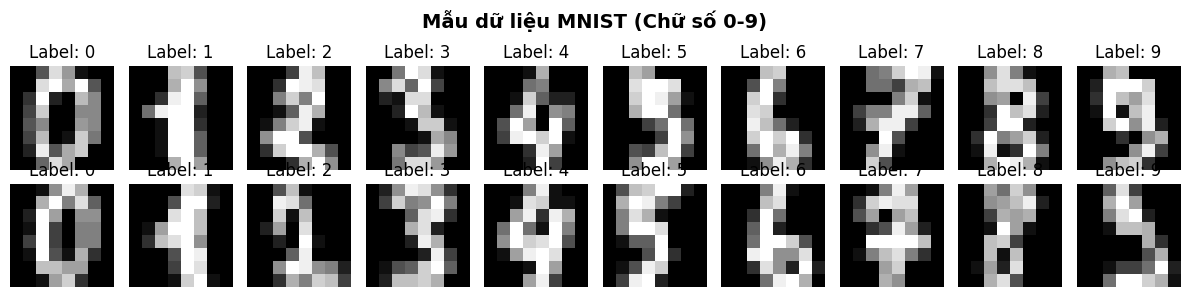

In [11]:
# Hiển thị một số mẫu
print("Trần Phương Anh - 6351071002")
print("\n📊 HIỂN THỊ MỘT SỐ MẪU TỪ DỮ LIỆU:")
fig, axes = plt.subplots(2, 10, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Label: {y_true[i]}')
    ax.axis('off')
plt.suptitle('Mẫu dữ liệu MNIST (Chữ số 0-9)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('mnist_samples.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: mnist_samples.png")
plt.show()

In [19]:
# Phân tích phân phối nhãn
print("Trần Phương Anh - 6351071002")
print("\nPHÂN PHỐI CÁC LỚP:")
unique, counts = np.unique(y_true, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Chữ số {label}: {count} mẫu ({count/len(y_true)*100:.1f}%)")

# Chuẩn hóa dữ liệu
print("\nCHUẨN HÓA DỮ LIỆU...")
X_normalized = X / 16.0  # Chuẩn hóa về [0, 1]
print("✓ Đã chuẩn hóa dữ liệu về khoảng [0, 1]")

Trần Phương Anh - 6351071002

PHÂN PHỐI CÁC LỚP:
  Chữ số 0: 178 mẫu (9.9%)
  Chữ số 1: 182 mẫu (10.1%)
  Chữ số 2: 177 mẫu (9.8%)
  Chữ số 3: 183 mẫu (10.2%)
  Chữ số 4: 181 mẫu (10.1%)
  Chữ số 5: 182 mẫu (10.1%)
  Chữ số 6: 181 mẫu (10.1%)
  Chữ số 7: 179 mẫu (10.0%)
  Chữ số 8: 174 mẫu (9.7%)
  Chữ số 9: 180 mẫu (10.0%)

CHUẨN HÓA DỮ LIỆU...
✓ Đã chuẩn hóa dữ liệu về khoảng [0, 1]


In [20]:
# Áp dụng K-Means Clustering
print("Trần Phương Anh - 6351071002")
print("\n" + "=" * 80)
print("ÁP DỤNG THUẬT TOÁN K-MEANS CLUSTERING")
print("=" * 80)

n_clusters = 10  # Số cụm = số chữ số (0-9)
print(f"\n Đang chạy K-Means với {n_clusters} cụm...")

kmeans = KMeans(
    n_clusters=n_clusters,
    init='k-means++',
    n_init=10,
    max_iter=300,
    random_state=42,
    verbose=0
)

y_pred = kmeans.fit_predict(X_normalized)
print("✓ Hoàn thành gom cụm!")

Trần Phương Anh - 6351071002

ÁP DỤNG THUẬT TOÁN K-MEANS CLUSTERING

 Đang chạy K-Means với 10 cụm...
✓ Hoàn thành gom cụm!


In [21]:
# Thông tin về các cụm
print("Trần Phương Anh - 6351071002")
print("\nTHÔNG TIN VỀ CÁC CỤM:")
unique_clusters, cluster_counts = np.unique(y_pred, return_counts=True)
for cluster_id, count in zip(unique_clusters, cluster_counts):
    print(f"  Cụm {cluster_id}: {count} mẫu ({count/len(y_pred)*100:.1f}%)")

print(f"\nInertia (tổng khoảng cách bình phương): {kmeans.inertia_:.2f}")

# Hàm để mapping cụm với nhãn thực tế (sử dụng Hungarian algorithm)
def map_clusters_to_labels(y_true, y_pred):
    """
    Ánh xạ các cụm với nhãn thực tế để tối đa hóa accuracy
    """
    # Tạo ma trận chi phí
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Sử dụng Hungarian algorithm để tìm mapping tốt nhất
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)

    # Tạo mapping dictionary
    mapping = {cluster: label for cluster, label in zip(col_ind, row_ind)}

    # Áp dụng mapping
    y_pred_mapped = np.array([mapping[cluster] for cluster in y_pred])

    return y_pred_mapped, mapping

print("\nĐANG ÁNH XẠ CÁC CỤM VỚI NHÃN THỰC TẾ...")
y_pred_mapped, cluster_mapping = map_clusters_to_labels(y_true, y_pred)
print("✓ Hoàn thành ánh xạ!")

print("\nBẢNG ÁNH XẠ CỤM -> NHÃN:")
for cluster, label in sorted(cluster_mapping.items()):
    print(f"  Cụm {cluster} → Chữ số {label}")

Trần Phương Anh - 6351071002

THÔNG TIN VỀ CÁC CỤM:
  Cụm 0: 176 mẫu (9.8%)
  Cụm 1: 179 mẫu (10.0%)
  Cụm 2: 89 mẫu (5.0%)
  Cụm 3: 226 mẫu (12.6%)
  Cụm 4: 198 mẫu (11.0%)
  Cụm 5: 182 mẫu (10.1%)
  Cụm 6: 181 mẫu (10.1%)
  Cụm 7: 157 mẫu (8.7%)
  Cụm 8: 241 mẫu (13.4%)
  Cụm 9: 168 mẫu (9.3%)

Inertia (tổng khoảng cách bình phương): 4551.78

ĐANG ÁNH XẠ CÁC CỤM VỚI NHÃN THỰC TẾ...
✓ Hoàn thành ánh xạ!

BẢNG ÁNH XẠ CỤM -> NHÃN:
  Cụm 0 → Chữ số 2
  Cụm 1 → Chữ số 0
  Cụm 2 → Chữ số 1
  Cụm 3 → Chữ số 8
  Cụm 4 → Chữ số 7
  Cụm 5 → Chữ số 6
  Cụm 6 → Chữ số 3
  Cụm 7 → Chữ số 5
  Cụm 8 → Chữ số 9
  Cụm 9 → Chữ số 4


Trần Phương Anh - 6351071002

SO SÁNH KẾT QUẢ GOM CỤM VỚI NHÃN THỰC TẾ

✓ Accuracy (sau ánh xạ): 0.7935 (79.35%)
✓ Adjusted Rand Index (ARI): 0.6669
  → Đo lường độ tương đồng giữa hai phân cụm
  → Giá trị từ -1 đến 1 (1 = hoàn toàn giống nhau)
✓ Normalized Mutual Information (NMI): 0.7394
  → Đo lường lượng thông tin chung giữa hai phân cụm
  → Giá trị từ 0 đến 1 (1 = hoàn toàn giống nhau)
✓ Silhouette Score: 0.1773
  → Đo lường chất lượng phân cụm
  → Giá trị từ -1 đến 1 (càng cao càng tốt)
✓ Davies-Bouldin Index: 1.9208
  → Đo lường tỷ lệ giữa khoảng cách trong cụm và giữa các cụm
  → Càng thấp càng tốt

MA TRẬN NHẦM LẪN (Confusion Matrix):

Dòng = Nhãn thực tế, Cột = Nhãn dự đoán
[[177   0   0   0   1   0   0   0   0   0]
 [  0  55  24   1   0   1   2   0  99   0]
 [  1   2 148  13   0   0   0   3   8   2]
 [  0   0   1 155   0   2   0   7   7  11]
 [  0   3   0   0 166   0   0   8   4   0]
 [  0   0   0   2   1 137   1   0   0  41]
 [  1   1   0   0   0   0 177   0   2   0]
 [  0 

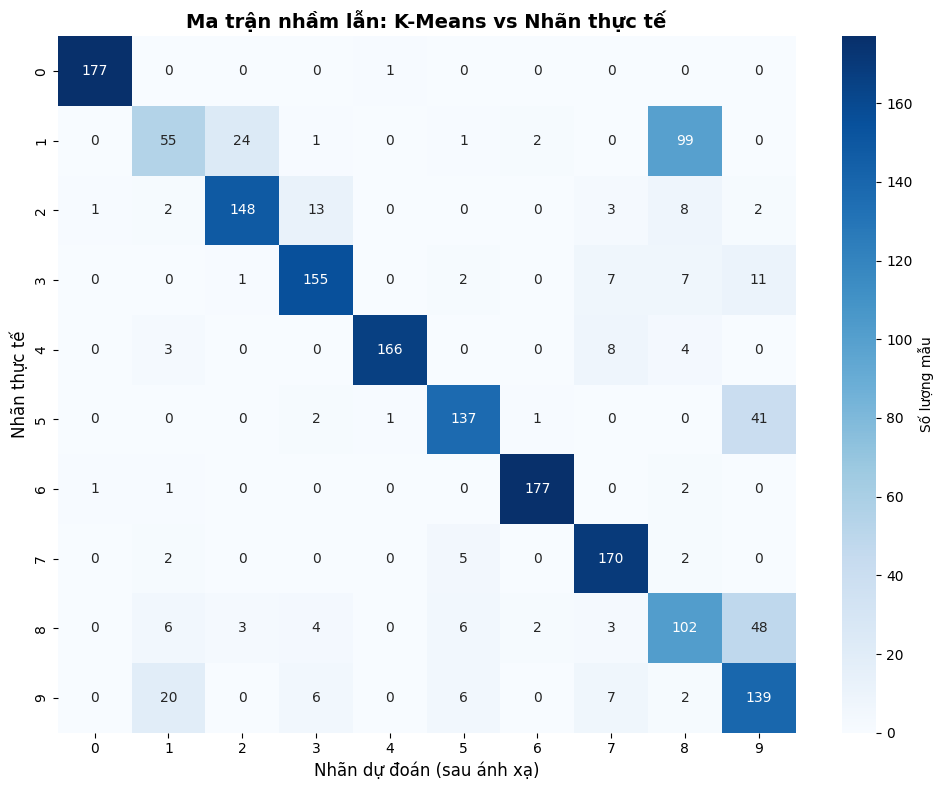


ACCURACY CHO TỪNG CHỮ SỐ:
  Chữ số 0: 0.9944 (99.44%) - 177/178 mẫu đúng
  Chữ số 1: 0.3022 (30.22%) - 55/182 mẫu đúng
  Chữ số 2: 0.8362 (83.62%) - 148/177 mẫu đúng
  Chữ số 3: 0.8470 (84.70%) - 155/183 mẫu đúng
  Chữ số 4: 0.9171 (91.71%) - 166/181 mẫu đúng
  Chữ số 5: 0.7527 (75.27%) - 137/182 mẫu đúng
  Chữ số 6: 0.9779 (97.79%) - 177/181 mẫu đúng
  Chữ số 7: 0.9497 (94.97%) - 170/179 mẫu đúng
  Chữ số 8: 0.5862 (58.62%) - 102/174 mẫu đúng
  Chữ số 9: 0.7722 (77.22%) - 139/180 mẫu đúng


In [22]:
# SO SÁNH KẾT QUẢ GOM CỤM VỚI NHÃN THỰC TẾ
print("Trần Phương Anh - 6351071002")
print("\n" + "=" * 80)
print("SO SÁNH KẾT QUẢ GOM CỤM VỚI NHÃN THỰC TẾ")
print("=" * 80)

# 1. Accuracy (sau khi mapping)
accuracy = accuracy_score(y_true, y_pred_mapped)
print(f"\n✓ Accuracy (sau ánh xạ): {accuracy:.4f} ({accuracy*100:.2f}%)")

# 2. Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_true, y_pred)
print(f"✓ Adjusted Rand Index (ARI): {ari:.4f}")
print(f"  → Đo lường độ tương đồng giữa hai phân cụm")
print(f"  → Giá trị từ -1 đến 1 (1 = hoàn toàn giống nhau)")

# 3. Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(y_true, y_pred)
print(f"✓ Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"  → Đo lường lượng thông tin chung giữa hai phân cụm")
print(f"  → Giá trị từ 0 đến 1 (1 = hoàn toàn giống nhau)")

# 4. Silhouette Score
silhouette = silhouette_score(X_normalized, y_pred, sample_size=1000)
print(f"✓ Silhouette Score: {silhouette:.4f}")
print(f"  → Đo lường chất lượng phân cụm")
print(f"  → Giá trị từ -1 đến 1 (càng cao càng tốt)")

# 5. Davies-Bouldin Index
db_index = davies_bouldin_score(X_normalized, y_pred)
print(f"✓ Davies-Bouldin Index: {db_index:.4f}")
print(f"  → Đo lường tỷ lệ giữa khoảng cách trong cụm và giữa các cụm")
print(f"  → Càng thấp càng tốt")

# Ma trận nhầm lẫn
print("\nMA TRẬN NHẦM LẪN (Confusion Matrix):")
conf_matrix = confusion_matrix(y_true, y_pred_mapped)
print("\nDòng = Nhãn thực tế, Cột = Nhãn dự đoán")
print(conf_matrix)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Số lượng mẫu'})
plt.title('Ma trận nhầm lẫn: K-Means vs Nhãn thực tế', fontsize=14, fontweight='bold')
plt.xlabel('Nhãn dự đoán (sau ánh xạ)', fontsize=12)
plt.ylabel('Nhãn thực tế', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Đã lưu: confusion_matrix.png")
plt.show()

# Tính accuracy cho từng chữ số
print("\nACCURACY CHO TỪNG CHỮ SỐ:")
for digit in range(10):
    mask = y_true == digit
    digit_accuracy = accuracy_score(y_true[mask], y_pred_mapped[mask])
    total_samples = np.sum(mask)
    correct_samples = np.sum(y_true[mask] == y_pred_mapped[mask])
    print(f"  Chữ số {digit}: {digit_accuracy:.4f} ({digit_accuracy*100:.2f}%) - "
          f"{correct_samples}/{total_samples} mẫu đúng")

Trần Phương Anh - 6351071002

TRỰC QUAN HÓA KẾT QUẢ BẰNG PCA (2D)

Đang giảm chiều dữ liệu xuống 2D bằng PCA...
✓ Hoàn thành! Tỷ lệ phương sai giải thích: 28.51%

✓ Đã lưu: kmeans_visualization.png


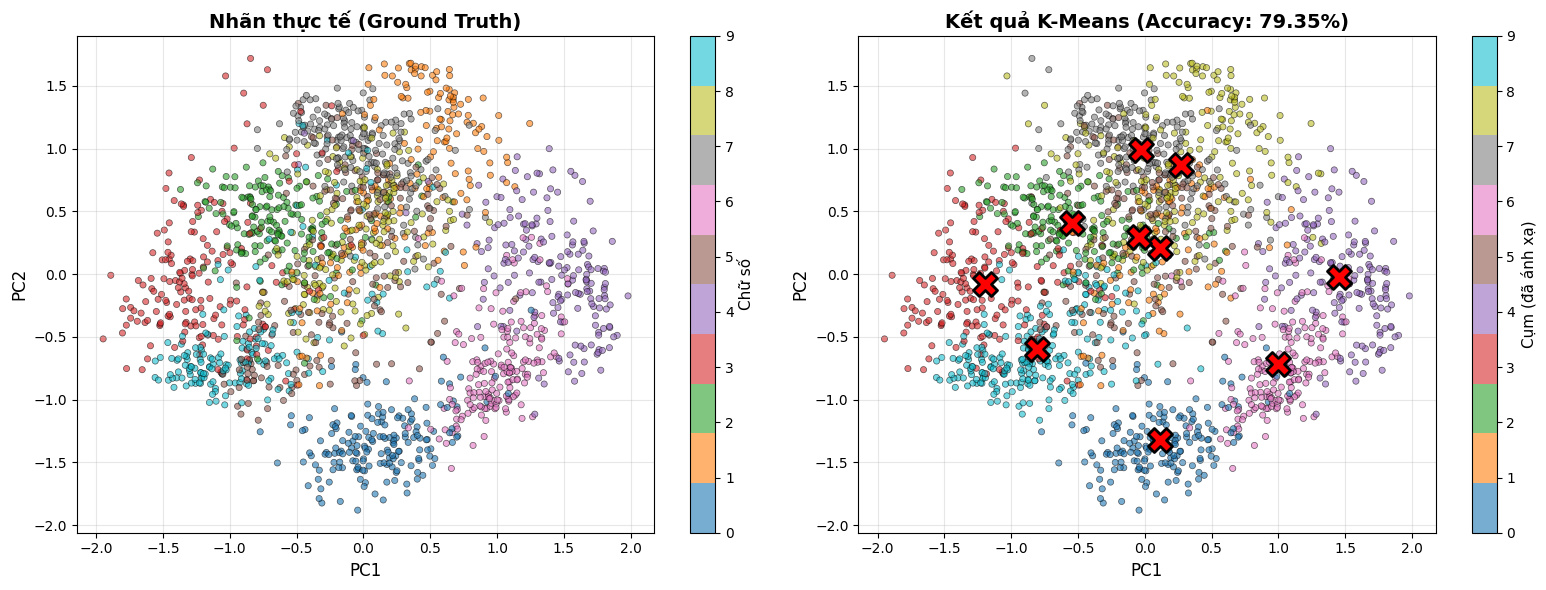


VÍ DỤ PHÂN LOẠI ĐÚNG VÀ SAI

✓ Số mẫu phân loại đúng: 1426 (79.4%)
✗ Số mẫu phân loại sai: 371 (20.6%)

✓ Đã lưu: correct_predictions.png


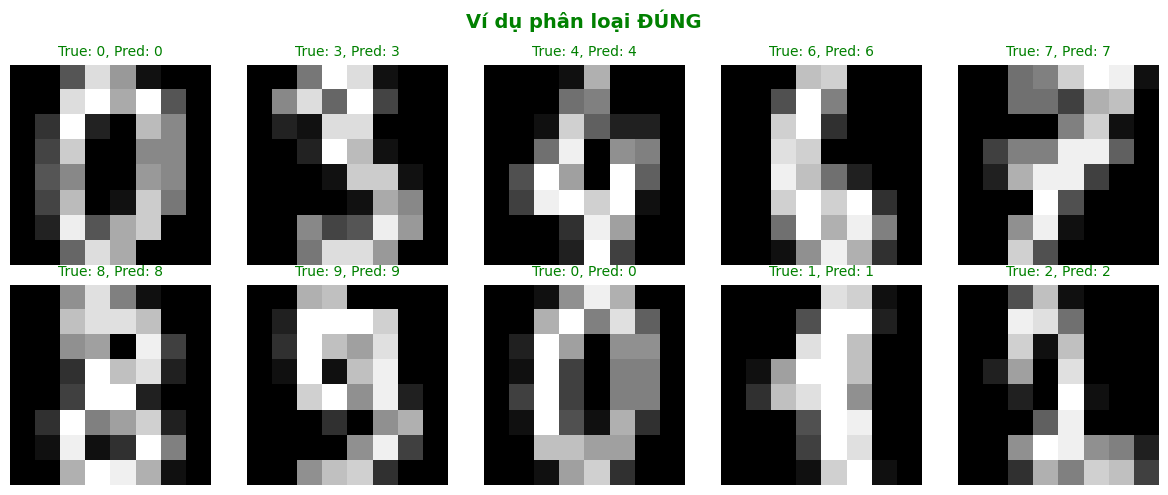

✓ Đã lưu: incorrect_predictions.png


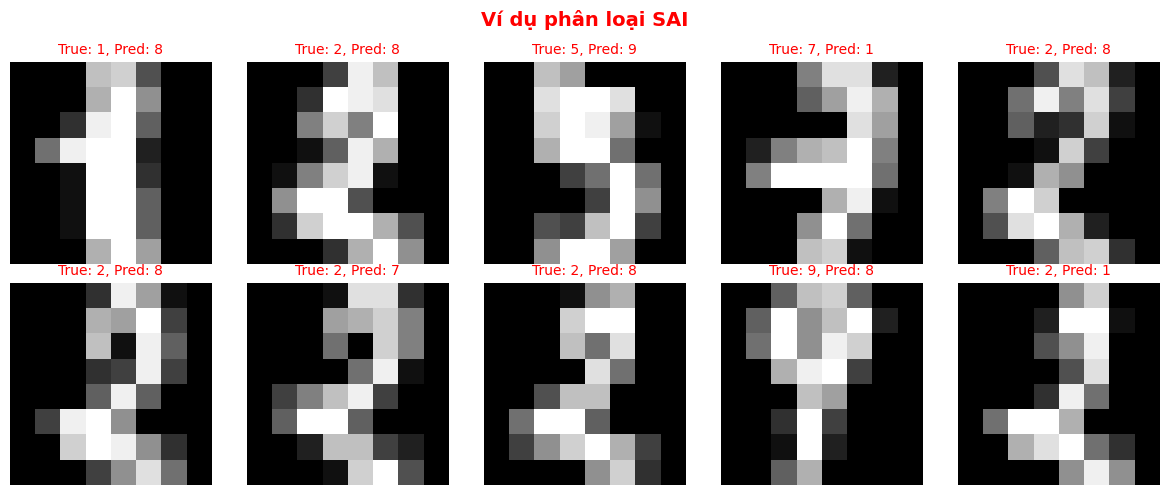

In [23]:
# TRỰC QUAN HÓA KẾT QUẢ BẰNG PCA
print("Trần Phương Anh - 6351071002")
print("\n" + "=" * 80)
print("TRỰC QUAN HÓA KẾT QUẢ BẰNG PCA (2D)")
print("=" * 80)

print("\nĐang giảm chiều dữ liệu xuống 2D bằng PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_normalized)
print(f"✓ Hoàn thành! Tỷ lệ phương sai giải thích: {sum(pca.explained_variance_ratio_):.2%}")

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ 1: Nhãn thực tế
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true,
                          cmap='tab10', s=20, alpha=0.6, edgecolors='black', linewidths=0.5)
axes[0].set_title('Nhãn thực tế (Ground Truth)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0], ticks=range(10))
cbar1.set_label('Chữ số', fontsize=11)

# Biểu đồ 2: Kết quả gom cụm (sau ánh xạ)
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_mapped,
                          cmap='tab10', s=20, alpha=0.6, edgecolors='black', linewidths=0.5)
axes[1].set_title(f'Kết quả K-Means (Accuracy: {accuracy:.2%})',
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=range(10))
cbar2.set_label('Cụm (đã ánh xạ)', fontsize=11)

# Vẽ tâm các cụm
centers_pca = pca.transform(kmeans.cluster_centers_)
for cluster, label in cluster_mapping.items():
    axes[1].scatter(centers_pca[cluster, 0], centers_pca[cluster, 1],
                   c='red', marker='X', s=300, edgecolors='black',
                   linewidths=2, zorder=10)
    axes[1].annotate(f'{label}', (centers_pca[cluster, 0], centers_pca[cluster, 1]),
                    fontsize=12, fontweight='bold', ha='center', va='center',
                    color='white')

plt.tight_layout()
plt.savefig('kmeans_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Đã lưu: kmeans_visualization.png")
plt.show()

# Hiển thị một số ví dụ phân loại đúng và sai
print("\n" + "=" * 80)
print("VÍ DỤ PHÂN LOẠI ĐÚNG VÀ SAI")
print("=" * 80)

correct_indices = np.where(y_true == y_pred_mapped)[0]
incorrect_indices = np.where(y_true != y_pred_mapped)[0]

print(f"\n✓ Số mẫu phân loại đúng: {len(correct_indices)} ({len(correct_indices)/len(y_true)*100:.1f}%)")
print(f"✗ Số mẫu phân loại sai: {len(incorrect_indices)} ({len(incorrect_indices)/len(y_true)*100:.1f}%)")

# Hiển thị ví dụ phân loại đúng
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Ví dụ phân loại ĐÚNG', fontsize=14, fontweight='bold', color='green')
for i, ax in enumerate(axes.flat):
    if i < len(correct_indices):
        idx = correct_indices[i]
        ax.imshow(digits.images[idx], cmap='gray')
        ax.set_title(f'True: {y_true[idx]}, Pred: {y_pred_mapped[idx]}',
                    fontsize=10, color='green')
        ax.axis('off')
plt.tight_layout()
plt.savefig('correct_predictions.png', dpi=300, bbox_inches='tight')
print("\n✓ Đã lưu: correct_predictions.png")
plt.show()

# Hiển thị ví dụ phân loại sai
if len(incorrect_indices) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle('Ví dụ phân loại SAI', fontsize=14, fontweight='bold', color='red')
    for i, ax in enumerate(axes.flat):
        if i < min(10, len(incorrect_indices)):
            idx = incorrect_indices[i]
            ax.imshow(digits.images[idx], cmap='gray')
            ax.set_title(f'True: {y_true[idx]}, Pred: {y_pred_mapped[idx]}',
                        fontsize=10, color='red')
            ax.axis('off')
    plt.tight_layout()
    plt.savefig('incorrect_predictions.png', dpi=300, bbox_inches='tight')
    print("✓ Đã lưu: incorrect_predictions.png")
    plt.show()

In [24]:
# Tổng kết
print("Trần Phương Anh - 6351071002")
print("\n" + "=" * 80)
print("TỔNG KẾT KẾT QUẢ")
print("=" * 80)
print(f"""
HIỆU SUẤT GOM CỤM K-MEANS TRÊN MNIST:

  ✓ Accuracy:                    {accuracy:.4f} ({accuracy*100:.2f}%)
  ✓ Adjusted Rand Index:         {ari:.4f}
  ✓ Normalized Mutual Info:      {nmi:.4f}
  ✓ Silhouette Score:            {silhouette:.4f}
  ✓ Davies-Bouldin Index:        {db_index:.4f}

  ✓ Số cụm:                      {n_clusters}
  ✓ Số mẫu phân loại đúng:       {len(correct_indices)}/{len(y_true)}
  ✓ Số mẫu phân loại sai:        {len(incorrect_indices)}/{len(y_true)}

CÁC FILE ĐÃ LƯU:
  • mnist_samples.png            - Mẫu dữ liệu MNIST
  • confusion_matrix.png         - Ma trận nhầm lẫn
  • kmeans_visualization.png     - Trực quan hóa 2D
  • correct_predictions.png      - Ví dụ phân loại đúng
  • incorrect_predictions.png    - Ví dụ phân loại sai

NHẬN XÉT:
  K-Means có thể gom cụm dữ liệu MNIST với độ chính xác khá tốt (~{accuracy*100:.0f}%),
  tuy nhiên vẫn thấp hơn so với các phương pháp supervised learning.
  Điều này cho thấy unsupervised learning có hạn chế khi không sử dụng nhãn.
""")

print("=" * 80)
print("✓ HOÀN THÀNH!")
print("=" * 80)

Trần Phương Anh - 6351071002

TỔNG KẾT KẾT QUẢ

HIỆU SUẤT GOM CỤM K-MEANS TRÊN MNIST:
  
  ✓ Accuracy:                    0.7935 (79.35%)
  ✓ Adjusted Rand Index:         0.6669
  ✓ Normalized Mutual Info:      0.7394
  ✓ Silhouette Score:            0.1773
  ✓ Davies-Bouldin Index:        1.9208
  
  ✓ Số cụm:                      10
  ✓ Số mẫu phân loại đúng:       1426/1797
  ✓ Số mẫu phân loại sai:        371/1797

CÁC FILE ĐÃ LƯU:
  • mnist_samples.png            - Mẫu dữ liệu MNIST
  • confusion_matrix.png         - Ma trận nhầm lẫn
  • kmeans_visualization.png     - Trực quan hóa 2D
  • correct_predictions.png      - Ví dụ phân loại đúng
  • incorrect_predictions.png    - Ví dụ phân loại sai

NHẬN XÉT:
  K-Means có thể gom cụm dữ liệu MNIST với độ chính xác khá tốt (~79%),
  tuy nhiên vẫn thấp hơn so với các phương pháp supervised learning.
  Điều này cho thấy unsupervised learning có hạn chế khi không sử dụng nhãn.

✓ HOÀN THÀNH!
